# Pairs Trading with Machine Learning
Jonathan Larkin

August, 2017

In developing a Pairs Trading strategy, finding valid, eligible pairs which exhibit unconditional mean-reverting behavior is of critical importance. This notebook walks through an example implementation of finding eligible pairs. We show how popular algorithms from Machine Learning can help us navigate a very high-dimensional seach space to find tradeable pairs.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

In [2]:
print "Numpy: %s " % np.__version__
print "Pandas: %s " % pd.__version__

Numpy: 1.11.1 
Pandas: 0.18.1 


In [3]:
study_date = "2016-12-31"

## Define Universe
We start by specifying that we will constrain our search for pairs to the a large and liquid single stock universe.

In [4]:
universe = Q1500US()

## Choose Data
In addition to pricing, let's use some fundamental and industry classification data. When we look for pairs (or model anything in quantitative finance), it is generally good to have an "economic prior", as this helps mitigate overfitting. I often see Quantopian users create strategies with a fixed set of pairs that they have likely chosen by some fundamental rationale ("KO and PEP should be related becuase..."). A purely fundamental approach is a fine way to search for pairs, however breadth will likely be low. As discussed in [The Foundation of Algo Success](https://blog.quantopian.com/the-foundation-of-algo-success/), you can maximize Sharpe by having high breadth (high number of bets). With `N` stocks in the universe, there are `N*(N-1)/2` pair-wise relationships. However, if we do a brute-force search over these, we will likely end up with many spurious results. As such, let's narrow down the search space in a reasonable way. In this study, I start with the following priors:

- Stocks that share loadings to common factors (defined below) in the past should be related in the future.
- Stocks of similar market caps should be related in the future.
- We should exclude stocks in the industry group "Conglomerates" (industry code 31055). Morningstar analysts classify stocks into industry groups primarily based on similarity in revenue lines. "Conglomerates" is a catch-all industry. As described in the [Morningstar Global Equity
Classification Structure manual](http://corporate.morningstar.com/us/documents/methodologydocuments/methodologypapers/equityclassmethodology.pdf): "If the company has more than three sources of revenue and
income and there is no clear dominant revenue and income stream, the company
is assigned to the Conglomerates industry." We should not expect these stocks to be good members of any pairs in the future. This turns out to have zero impact on the Q500 and removes only 1 stock from the Q1500, but I left this idea in for didactic purposes.
- Creditworthiness in an important feature in future company performance. It's difficult to find credit spread data and map the reference entity to the appropriate equity security. There is a model, colloquially called the [Merton Model](http://www.investopedia.com/terms/m/mertonmodel.asp), however, which takes a contingent claims approach to modeling the capital structure of the firm. The output is an implied probability of default. Morningstar analysts calculate this for us and the field is called `financial_health_grade`. A full description of this field is in the [help docs](https://www.quantopian.com/help/fundamentals#asset-classification).

In [5]:
pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
)

In [6]:
res = run_pipeline(pipe, study_date, study_date)
res.index = res.index.droplevel(0)  # drop the single date from the multi-index

In [7]:
print res.shape
res.head()

(1500, 3)


,Financial Health,Industry,Market Cap
Equity(2 [ARNC]),C,10106,4
Equity(24 [AAPL]),A,31167,4
Equity(52 [ABM]),B,31054,3
Equity(53 [ABMD]),A,20639,3
Equity(62 [ABT]),B,20639,4


In [8]:
# remove stocks in Industry "Conglomerates"
res = res[res['Industry']!=31055]
print res.shape

(1499, 3)


In [9]:
# remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
print res.shape

(1499, 3)


In [10]:
# replace the categorical data with numerical scores per the docs
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
               u'B': 0.3,
               u'C': 0.7,
               u'D': 0.9,
               u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [11]:
res.describe()

,Financial Health,Industry,Market Cap
count,1499.000000,1499.000000,1499.000000
mean,0.447432,20262.618412,3.377585
std,0.266508,9205.899868,0.654800
min,0.100000,10101.000000,2.000000
25%,0.300000,10320.000000,3.000000
50%,0.300000,20635.000000,3.000000
75%,0.700000,31054.000000,4.000000
max,1.000000,31169.000000,4.000000


## Define Horizon
We are going to work with a daily return horizon in this strategy.

In [12]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp(study_date) - pd.DateOffset(months=24),
    end_date=pd.Timestamp(study_date)
)

In [13]:
pricing.shape

(505, 1499)

In [14]:
returns = pricing.pct_change()

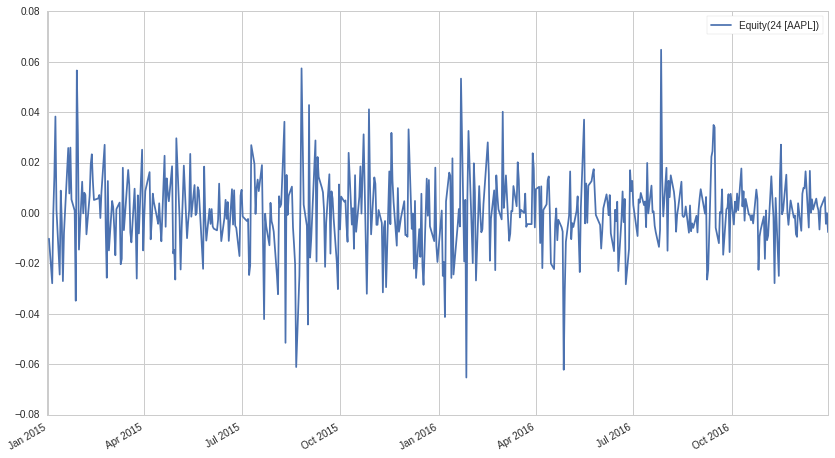

In [15]:
returns[symbols(['AAPL'])].plot();

In [16]:
# we can only work with stocks that have the full return series
returns = returns.iloc[1:,:].dropna(axis=1)

In [17]:
print returns.shape

(504, 1429)


## Find Candidate Pairs
Given the pricing data and the fundamental and industry/sector data, we will first classify stocks into clusters and then, within clusters, looks for strong mean-reverting pair relationships.

The first hypothesis above is that "Stocks that share loadings to common factors in the past should be related in the future". Common factors are things like sector/industry membership and widely known ranking schemes like momentum and value. We could specify the common factors *a priori* to well known factors, or alternatively, we could let the data speak for itself. In this post we take the latter approach. We use PCA to reduce the dimensionality of the returns data and extract the historical latent common factor loadings for each stock. For a nice visual introduction to what PCA is doing, take a look [here](http://setosa.io/ev/principal-component-analysis/) (thanks to Gus Gordon for pointing out this site).

We will take these features, add in the fundamental features, and then use the `DBSCAN` **unsupervised** [clustering algorithm](http://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#dbscan) which is available in [`scikit-learn`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). Thanks to Thomas Wiecki for pointing me to this specific clustering technique and helping with implementation. Initially I looked at using `KMeans` but `DBSCAN` has advantages in this use case, specifically

- `DBSCAN` does not cluster *all* stocks; it leaves out stocks which do not neatly fit into a cluster;
- relatedly, you do not need to specify the number of clusters.

The clustering algorithm will give us sensible *candidate* pairs. We will need to do some validation in the next step.

### PCA Decomposition and DBSCAN Clustering

In [18]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, n_components=50, whiten=False)

In [19]:
pca.components_.T.shape

(1429, 50)

We have reduced data now with the first `N_PRIN_COMPONENTS` principal component loadings. Let's add some fundamental values as well to make the model more robust.

In [20]:
X = np.hstack(
    (pca.components_.T,
     res['Market Cap'][returns.columns].values[:, np.newaxis],
     res['Financial Health'][returns.columns].values[:, np.newaxis])
)

print X.shape

(1429, 52)


In [21]:
X = preprocessing.StandardScaler().fit_transform(X)
print X.shape

(1429, 52)


In [22]:
clf = DBSCAN(eps=1.9, min_samples=3)
print clf

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nClusters discovered: %d" % n_clusters_

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

Clusters discovered: 11


In [23]:
# the initial dimensionality of the search was
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 1020306 


In [24]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [25]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs to evaluate: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 11
Pairs to evaluate: 2120


We have reduced the search space for pairs from >1mm to approximately 2,000.

### Cluster Visualization
We have found 11 clusters. The data are clustered in 52 dimensions. As an attempt to visualize what has happened in 2d, we can try with [T-SNE](https://distill.pub/2016/misread-tsne/). T-SNE is an algorithm for visualizing very high dimension data in 2d, created in part by Geoff Hinton. We visualize the discovered pairs to help us gain confidence that the `DBSCAN` output is sensible; i.e., we want to see that T-SNE and DBSCAN both find our clusters.

In [26]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

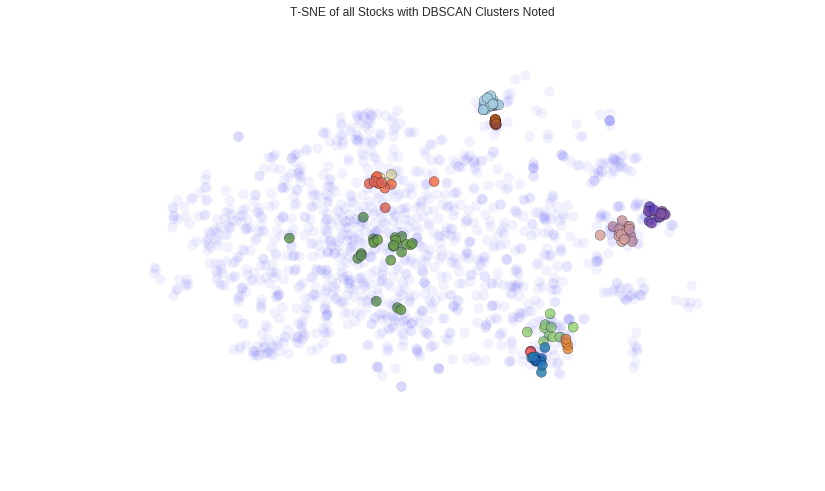

In [27]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

plt.scatter(
    X_tsne[(labels!=-1), 0],
    X_tsne[(labels!=-1), 1],
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0],
    X_tsne[(clustered_series_all==-1).values, 1],
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

We can also see how many stocks we found in each cluster and then visualize the normalized time series of the members of a handful of the smaller clusters.

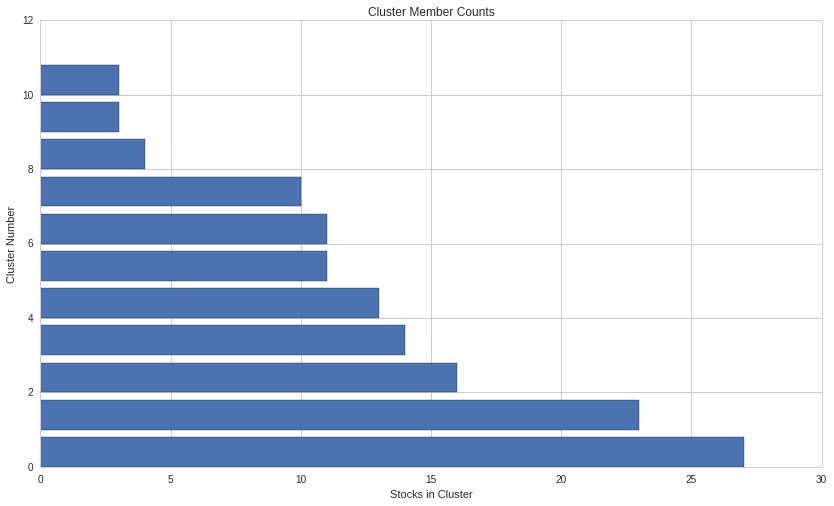

In [28]:
plt.barh(
    xrange(len(clustered_series.value_counts())),
    clustered_series.value_counts()
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number');

To again visualize if our clustering is doing anything sensible, let's look at a few clusters (for reproducibility, keep all random state and dates the same in this notebook).

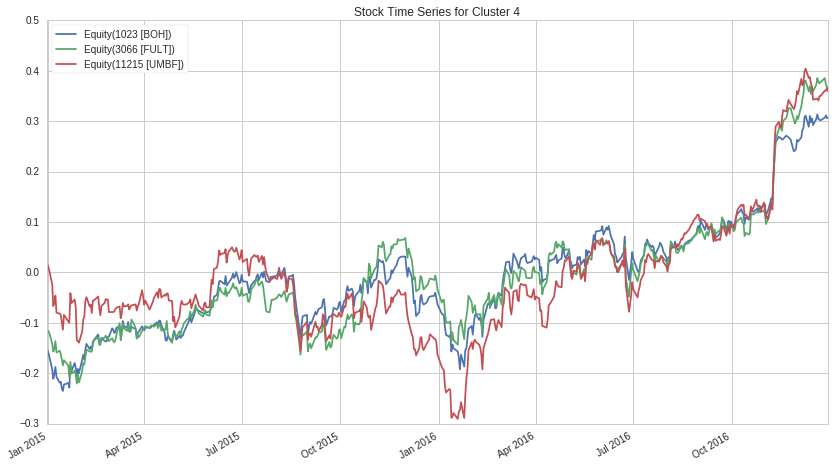

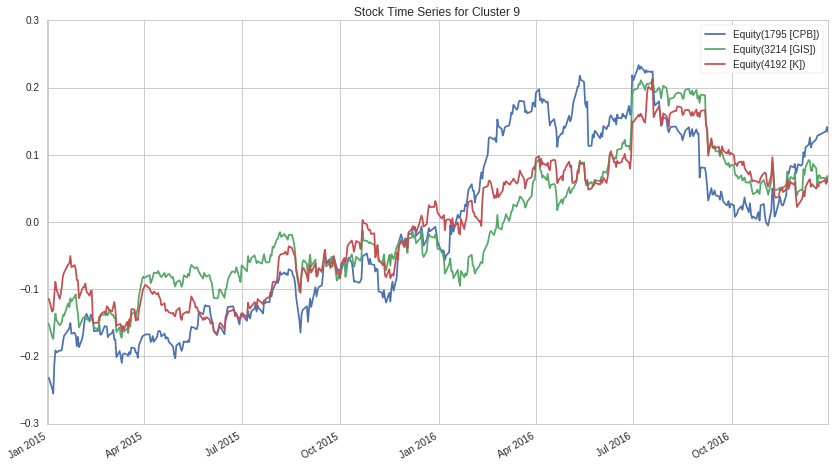

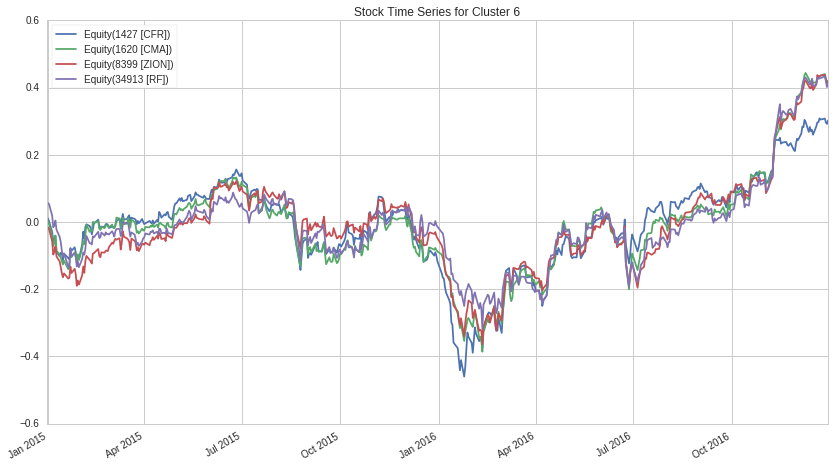

In [29]:
# get the number of stocks in each cluster
counts = clustered_series.value_counts()

# let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

We might be interested to see how a cluster looks for a particular stock. Large bank stocks share similar strict regulatory oversight and are similarly economic and interest rate sensitive. We indeed see that our clustering has found a bank stock cluster.

In [30]:
which_cluster = clustered_series.loc[symbols('JPM')]
clustered_series[clustered_series == which_cluster]

Equity(903 [BK])       2
Equity(5117 [MTB])     2
Equity(5479 [NTRS])    2
Equity(5769 [PBCT])    2
Equity(7152 [STI])     2
Equity(8151 [WFC])     2
Equity(16850 [BBT])    2
Equity(20088 [GS])     2
Equity(25006 [JPM])    2
Equity(25010 [USB])    2
dtype: int64

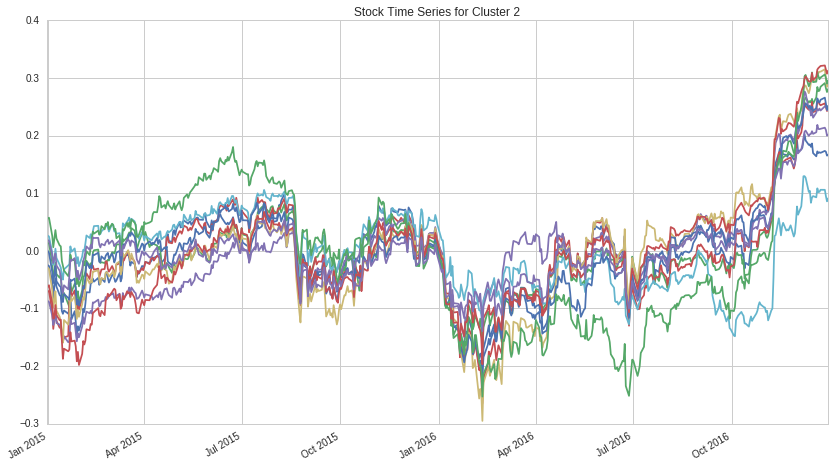

In [31]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

Now that we have sensible clusters of common stocks, we can validate the cointegration relationships.

In [32]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [33]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [34]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [35]:
pairs

[(Equity(161 [AEP]), Equity(1665 [CMS])),
 (Equity(161 [AEP]), Equity(2434 [ED])),
 (Equity(161 [AEP]), Equity(8140 [WEC])),
 (Equity(161 [AEP]), Equity(21964 [XEL])),
 (Equity(161 [AEP]), Equity(36098 [AWK])),
 (Equity(612 [ATO]), Equity(1665 [CMS])),
 (Equity(612 [ATO]), Equity(21964 [XEL])),
 (Equity(612 [ATO]), Equity(24783 [AEE])),
 (Equity(1665 [CMS]), Equity(2434 [ED])),
 (Equity(1665 [CMS]), Equity(8140 [WEC])),
 (Equity(1665 [CMS]), Equity(21964 [XEL])),
 (Equity(1665 [CMS]), Equity(24783 [AEE])),
 (Equity(1665 [CMS]), Equity(36098 [AWK])),
 (Equity(2071 [D]), Equity(2330 [DTE])),
 (Equity(2071 [D]), Equity(5792 [PCG])),
 (Equity(2071 [D]), Equity(6090 [PNW])),
 (Equity(2071 [D]), Equity(8265 [WR])),
 (Equity(2071 [D]), Equity(14372 [EIX])),
 (Equity(2071 [D]), Equity(24064 [CNP])),
 (Equity(2330 [DTE]), Equity(6090 [PNW])),
 (Equity(2330 [DTE]), Equity(8265 [WR])),
 (Equity(2434 [ED]), Equity(8140 [WEC])),
 (Equity(2434 [ED]), Equity(21964 [XEL])),
 (Equity(2968 [NEE]), Equit

In [36]:
print "We found %d pairs." % len(pairs)

We found 90 pairs.


In [37]:
print "In those pairs, there are %d unique tickers." % len(np.unique(pairs))

In those pairs, there are 76 unique tickers.


### Pair Visualization
Lastly, for the pairs we found and validated, let's visualize them in 2d space with T-SNE again.

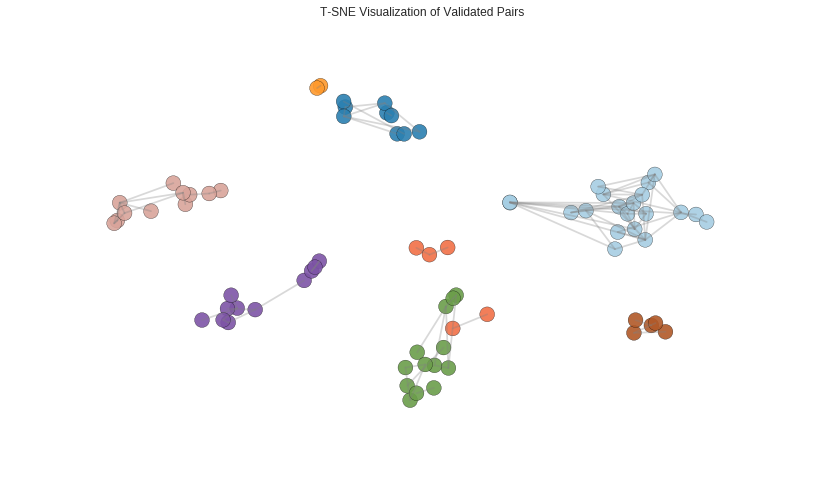

In [38]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0].symbol
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]

    ticker2 = pair[0].symbol
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
      
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');
        
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');


## Conclusion and Next Steps

We have found a nice number of pairs to use in a pairs trading strategy. Note that the unique number of stocks is less than the number of pairs. This means that the same stock, e.g., AEP, is in more than one pair. This is fine, but we will need to take some special precautions in the **Portfolio Construction** stage to avoid excessive concentration in any one stock. Happy hunting for pairs!

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*